In [ ]:
#!pip install statsmodels
#!pip install seaborn
#!pip install tqmd
#!pip install geopandas

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import zipfile
import seaborn as sns
from matplotlib import pyplot as plt
import requests
import os
from tqdm import tqdm

In [199]:
import warnings

warnings.filterwarnings('ignore')

### Style definitions

In [4]:
FONT_SIZE = 16

plt.style.use('seaborn-v0_8')
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE)
plt.rc('axes', labelsize=FONT_SIZE)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=FONT_SIZE)
plt.rc("savefig", bbox='tight')
plt.rc("savefig", dpi=300) 
sns.set(rc=
    {"font.size": FONT_SIZE,
     "axes.titlesize": FONT_SIZE,
     "axes.labelsize": FONT_SIZE,
     "xtick.labelsize": 14,
     "ytick.labelsize": 14,
     "legend.fontsize": FONT_SIZE,
     "legend.title_fontsize": FONT_SIZE,
    }
)

### Plot Utilities

In [ ]:
def plot_germany(ax, color='grey'):
    if not os.path.exists('plz-1stellig.shp'):
        r = requests.get('https://downloads.suche-postleitzahl.org/v2/public/plz-1stellig.shp.zip')
        with open('plz-1stellig.shp.zip', 'wb') as fd:
            fd.write(r.content)
        with zipfile.ZipFile('plz-1stellig.shp.zip', 'r') as zip_ref:
            zip_ref.extractall('plz-1stellig.shp')
            os.remove('plz-1stellig.shp.zip')
    plz_shape_df = gpd.read_file('plz-1stellig.shp', dtype={'plz': str})
    plz_shape_df.plot(ax=ax, color=color, alpha=1., edgecolor="face", linewidth=0.4)

### Data

In [160]:
BASE_PATH = '/home/carl/projects/gwl_neu'
DATA_PATH = '/home/carl/projects/gwl_neu/data'
FIGURES_PATH = '/home/carl/projects/gwl_neu/figures'

static_df = pd.read_feather(os.path.join(DATA_PATH, 'static.feather'))
gwl_df = pd.read_feather(os.path.join(DATA_PATH, 'temporal.feather')).set_index(['proj_id', 'time'])

### Fig 01: Introduction to Groundwater level data

In [ ]:
fig_01, ax = plt.subplots(1, 1, figsize=(12, 8))

plot_germany(ax)

agg_df = gwl_df[['gwl']].groupby(axis=0, level=0).count()
agg_df = agg_df.merge(static_df[['lat', 'lon']], left_index=True, right_index=True)
gdf = gpd.GeoDataFrame(
    agg_df, geometry=gpd.points_from_xy(agg_df['lon'], agg_df['lat']))
gdf.plot(column='gwl', ax=ax, legend=True, cmap='YlGnBu', markersize=4, aspect=1.)
ax.set(
    xlabel='longitude',
    ylabel='latitude',
)
fig_01.savefig(os.path.join(FIGURES_PATH, 'fig01.pdf'), format='pdf')

### Fig. 02: Examples of groundwater level time series

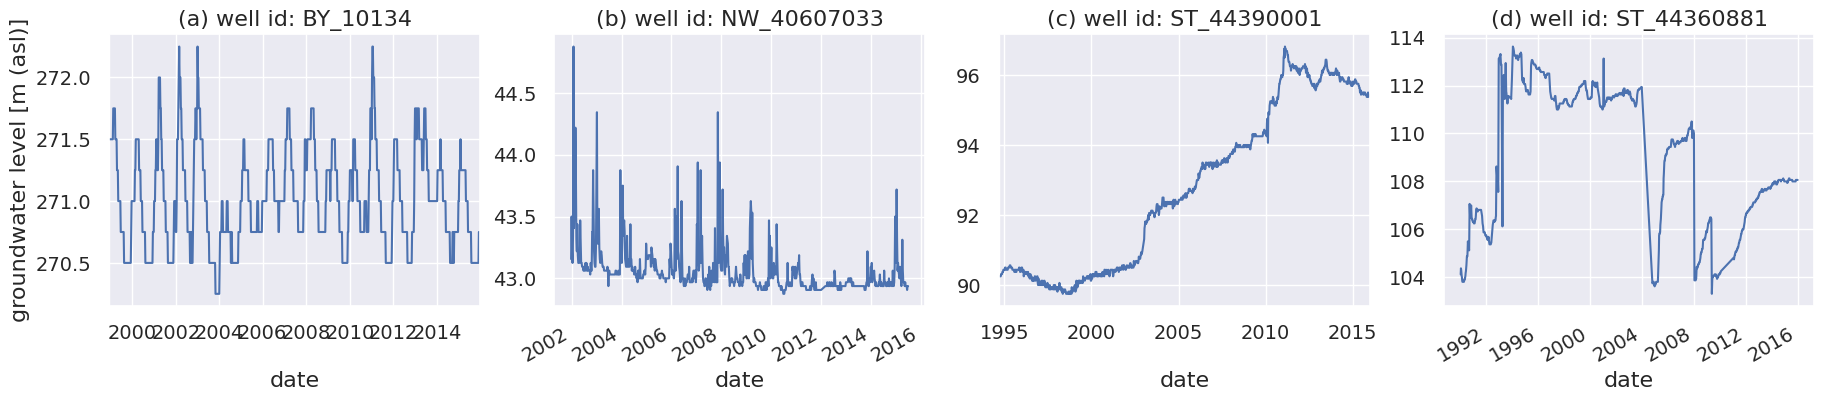

In [96]:
#wells = ['BY_10134', 'NI_9850360', 'NI_9610811', 'NW_40607033',
#         'NW_60090108', 'ST_44390001', 'BB_31481932', 'HE_8018',
#         'ST_44360881', 'ST_46350389', 'TH_5140000063', 'RP_2511120600']

wells = ['BY_10134', 'NW_40607033', 'ST_44390001', 'ST_44360881']
letters = 'abcd'

fig_02, ax = plt.subplots(1, 4, figsize=(22, 4))
plt.subplots_adjust(hspace=0.45)

for j in range(4):
    gwl_df[gwl_df.index.get_level_values('proj_id') == wells[j]]['gwl'].droplevel(0, axis=0).plot(title=f'({letters[j]}) well id: {wells[j]}', ax=ax[j])
    ax[j].set(xlabel="date")
    if j == 0:
        ax[j].set(ylabel="groundwater level [m (asl)]")

fig_02.align_labels()
fig_02.savefig(os.path.join(FIGURES_PATH, 'fig02.pdf'), format='pdf')

### Fig 03: spatial interpolation setups

In [ ]:
ref_proj_ids = [
    'BB_33522338', 'BB_34402050', 'BB_34426100', 'BB_36441970',
    'BB_39431451', 'BW_100-517-0', 'BW_100-813-7', 'BW_101-713-8',
    'BW_101-812-0', 'BW_103-714-0', 'BW_103-763-0', 'BW_104-112-1',
    'BW_107-309-4', 'BW_107-517-2', 'BW_107-666-2', 'BW_109-812-6',
    'BW_110-116-6', 'BW_111-568-6', 'BW_111-813-7', 'BW_115-113-3',
    'BW_115-114-5', 'BW_116-721-2', 'BW_119-765-9', 'BW_119-771-0',
    'BW_119-813-3', 'BW_122-021-6', 'BW_125-257-2', 'BW_131-115-0',
    'BW_132-721-5', 'BW_135-064-6', 'BW_135-769-9', 'BW_139-119-9',
    'BW_145-771-8', 'BW_154-772-0', 'BW_156-770-6', 'BW_158-767-0',
    'BW_160-768-0', 'BW_164-772-6', 'BW_170-772-3', 'BW_172-772-2',
    'BW_177-772-5', 'BW_188-258-0', 'BW_193-769-2', 'BW_2010-813-1',
    'BW_4-812-8', 'BW_59-568-8', 'BY_11148', 'BY_83614', 'BY_9182',
    'HE_11738', 'HE_12447', 'HE_13622', 'HE_5754', 'HE_5798',
    'HE_6336', 'HE_6615', 'HE_7095', 'HE_7945', 'HE_8106', 'HE_8126',
    'HE_8999', 'HE_9534', 'HE_9595', 'HE_9620', 'HE_9692',
    'NI_100000467', 'NI_100000644', 'NI_100000670', 'NI_100000730',
    'NI_100000732', 'NI_100000914', 'NI_200000660', 'NI_200001410',
    'NI_40501911', 'NI_40502371', 'NI_40507101', 'NI_40507140',
    'NI_9700168', 'NI_9700201', 'NW_110320037', 'NW_129660334',
    'NW_59620286', 'NW_60100205', 'NW_70195213', 'NW_70195316',
    'NW_70276018', 'NW_80100247', 'NW_80301680', 'NW_91122405',
    'NW_91130104', 'NW_91141102', 'NW_91167309', 'NW_91173607',
    'SH_10L56010001', 'SN_49420761', 'SN_49430964', 'SN_53403678',
    'SN_54403689', 'ST_31380006', 'ST_41300022'
]

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    haver_formula = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    r = 6371
    dist = 2 * r * np.arcsin(np.sqrt(haver_formula))
    return pd.Series(dist)

In [ ]:
from matplotlib.lines import Line2D

TARGET_LON = 10.75
TARGET_LAT = 50.5

fig_03, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,12))

plot_germany(ax1)
plot_germany(ax2)


## local interpolation
circle1 = plt.Circle((TARGET_LON, TARGET_LAT), 1.4, color='#922a59ff', fill=False)
ax1.add_patch(circle1)
_df = well_meta_df[['lat', 'lon']].copy().reset_index()
_df['target_lon'] = TARGET_LON
_df['target_lat'] = TARGET_LAT
_df['dist'] = haversine(_df['target_lon'], _df['target_lat'], _df['lon'], _df['lat'])
_df = _df[_df['dist'] < 120]
sample_weights = -_df['dist']
sample_weights -= sample_weights.min() - 0.01
sample1 = _df.sample(6, weights=sample_weights, replace=False, random_state=1)
sample2 = _df.sample(6, weights=sample_weights, replace=False, random_state=16)
gdf0 = gpd.GeoDataFrame(
    sample1, geometry=gpd.points_from_xy(sample1['lon'], sample1['lat']))
gdf1 = gpd.GeoDataFrame(
    sample2, geometry=gpd.points_from_xy(sample2['lon'], sample2['lat']))
gdf0.plot(color='orange', marker='s', markersize=30, ax=ax1, aspect=1.0)
gdf1.plot(color='#6cebdbff', marker='s', markersize=30, ax=ax1, aspect=1.0)
for lon, lat in sample1[['lon', 'lat']].values:
    ax1.plot([TARGET_LON, lon], [TARGET_LAT, lat], color='orange', linestyle='dashed', linewidth=1.0)
for lon, lat in sample2[['lon', 'lat']].values:
    ax1.plot([TARGET_LON, lon], [TARGET_LAT, lat], color='#6cebdb99', linestyle='dashed', linewidth=1.0)
ax1.plot(TARGET_LON, TARGET_LAT, marker='X', markersize=15, markerfacecolor='#922a59ff')
ax1.set(ylabel='latitude', xlabel='longitude', title='(a) local interpolation')

## global interpolation
_df = well_meta_df.loc[ref_proj_ids, ['lat', 'lon']]
gdf2 = gpd.GeoDataFrame(
    _df, geometry=gpd.points_from_xy(_df['lon'], _df['lat']))
for lon, lat in _df[['lon', 'lat']].values:
    ax2.plot([TARGET_LON, lon], [TARGET_LAT, lat], color='#80c55f99', linestyle='dashed', linewidth=1.0)
ax2.plot(TARGET_LON, TARGET_LAT, marker='X', markersize=15, markerfacecolor='#922a59ff')
gdf2.plot(color='#80c55fff', markersize=30, ax=ax2, aspect=1.0)
ax2.set(xlabel='longitude', title='(b) global interpolation')

## legend
legend_elements = [
    Line2D([0], [0], marker='X', color='#FFFFFF00', label='target location', markerfacecolor='#922a59ff', markersize=10),
    Line2D([0], [0], color='#922a59ff', lw=2, label='local lookup bound.'),
    Line2D([0], [0], marker='s', color='#FFFFFF00', label='random local reference well (sampling a)', markerfacecolor='orange', markersize=10),
    Line2D([0], [0], marker='s', color='#FFFFFF00', label='random local reference well (sampling b)', markerfacecolor='#6cebdbff', markersize=10),    
    Line2D([0], [0], marker='o', color='#FFFFFF00', label='fixed global reference well', markerfacecolor='#80c55fff', markersize=10),
]
ax2.legend(handles=legend_elements, bbox_to_anchor=(1.88, 1.03), loc='upper right')
fig_03.savefig(os.path.join(FIGURES_PATH, 'fig03.pdf'), format='pdf', dpi=300.0)

### Fig 04: Metrics

In [6]:
MODELS = ['nhits', 'tft', 'tft_local_interpolation', 'tft_global_interpolation']

metrics = []
for model_name in MODELS:
    _df = pd.read_feather(os.path.join(BASE_PATH, 'results', 'metrics', f'{model_name}_metrics.feather'))
    _df['model'] = model_name
    metrics.append(_df)
metrics_df = pd.concat(metrics).reset_index(drop=True)

nhits_subset = metrics_df[(metrics_df['model'] == 'nhits') & (metrics_df['proj_id'].isin(metrics_df.loc[metrics_df['model'] == 'tft_global_interpolation', 'proj_id']))].copy()
nhits_subset['model'] = 'nhits_subset'
tft_subset = metrics_df[(metrics_df['model'] == 'tft') & (metrics_df['proj_id'].isin(metrics_df.loc[metrics_df['model'] == 'tft_global_interpolation', 'proj_id']))].copy()
tft_subset['model'] = 'tft_subset'
metrics_df = pd.concat([metrics_df, nhits_subset, tft_subset]).reset_index(drop=True)

metrics_df

metric,proj_id,horizon,Interval Score,NSE,nRMSE,rMBE,model
0,BB_25470023,1,1.203,0.961,0.106,0.007,nhits
1,BB_25470023,2,1.378,0.939,0.133,0.019,nhits
2,BB_25470023,3,1.400,0.918,0.155,0.025,nhits
3,BB_25470023,4,1.659,0.902,0.170,0.038,nhits
4,BB_25470023,5,1.836,0.888,0.182,0.055,nhits
...,...,...,...,...,...,...,...
193179,TH_5633900114,4,1.217,0.904,0.163,0.030,tft_subset
193180,TH_5633900114,5,1.580,0.828,0.256,0.103,tft_subset
193181,TH_5633900114,6,2.031,0.650,0.373,0.212,tft_subset
193182,TH_5633900114,7,2.452,0.470,0.458,0.298,tft_subset


In [ ]:
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from matplotlib import colormaps
from matplotlib.patches import Patch


colors = colormaps['Set2'].colors

HORIZON = 8
models = ['nhits', 'tft', 'nhits_subset', 'tft_subset', 'tft_local_interpolation', 'tft_global_interpolation']

fig_04, ax = plt.subplots(6, 4, figsize=(22, 5), sharey=True)

for j, (metric, _range) in enumerate([('NSE', (-1,1)), ('nRMSE', (0., 1)), ('rMBE', (-0.5, 0.5)), ('Interval Score', (0., 4.))]):
    for i, model in enumerate(models):
        x = metrics_df[(metrics_df['model'] == model) & (metrics_df['horizon'] == HORIZON)][metric].replace([np.inf, -np.inf], np.nan).dropna().values
        x_d = np.linspace(-1,4, 2000)
        
        
        kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
        kde.fit(x[:, None])
        logprob = kde.score_samples(x_d[:, None])
        y_d = np.exp(logprob)
        if metric == 'NSE':
            y_d *= 2
        elif metric == 'Interval Score':
            y_d *= 4
            
        if j == 0 and i == 5:
            ax[i, j].set_ylabel(f'horizon = {HORIZON}w')
        
        # plotting the distribution
        ax[i, j].plot(x_d, y_d, color="#f0f0f0", lw=1)
        ax[i, j].fill_between(x_d, y_d, alpha=1, color=colors[i])
              
        # setting uniform x and y lims
        ax[i, j].set_xlim(_range)
        #ax[i, j].set_ylim(0, 8)

        # make background transparent
        rect = ax[i, j].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax[i, j].set_yticklabels([])
        ax[i, j].grid(False)
        
        if i == 5:
            if HORIZON == 8:
                ax[i, j].set_xlabel(metric)
        else:
            ax[i, j].set_xticklabels([])

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax[i, j].spines[s].set_visible(False)
    
    #if metric != 'rMBE':
    #    ax[6, j].set_ylim(0, 1)
    #    rect = ax[6, j].patch
    #    rect.set_alpha(0)
    #    _df = metrics_df[metrics_df['horizon'] == HORIZON].replace([np.inf, -np.inf], np.nan).dropna()
    #    sns.ecdfplot(data=_df, x="NSE", palette=colors, hue='model', ax=ax[6, j], hue_order=['nhits', 'tft', 'nhits_subset', 'tft_subset', 'tft_local_interpolation', 'tft_global_interpolation'], legend=False)
    #    ax[6, j].set_xlim(_range)

plt.subplots_adjust(hspace=-.85)

legend_elements = [Patch(facecolor=colors[i], edgecolor=None, label=model) for i, model in enumerate(['N-HiTS', 'TFT', 'N-HiTS (subset)', 'TFT (subset)', 'TFT local interpolation', 'TFT global interpolation'])]
if HORIZON == 1:
    fig_04.legend(handles=legend_elements,mode = "expand", ncols=6, bbox_to_anchor=(0.1, 0.9, 0.78, 0.01))
fig_04.savefig(os.path.join(FIGURES_PATH, 'fig04b.pdf'), format='pdf', dpi=300.0)
plt.show()

### Fig 05: Forecast error by geologic attributes

In [ ]:
ROCK_TYPE_CHANNELS = ['n/a', 'sediment', 'metamorphic', 'pyrogenic', 'G']
CAVITY_TYPE_CHANNELS = ['k.A.', 'porous', 'K/P', 'karst', 'fractured/karst', 'nb', 'G']
KF_MAP = {
    0: 'n/a',
    1: 'high',
    2: 'high',
    8: 'high',
    3: 'medium',
    4: 'medium',
    9: 'medium',
    12: 'medium',
    5: 'low',
    6: 'low',
    7: 'low',
    10: 'low',
    11: 'n/a',
    99: 'n/a',
}
colors = colormaps['Set2'].colors
metric = 'nRMSE'
xlim = (0., 1.)
model_dict = {'tft': 'TFT', 'nhits': 'N-HiTS'}

_df = metrics_df[(metrics_df['horizon'] == 1) & (metrics_df['model'].isin(['tft', 'nhits']))][['proj_id', 'model', metric]].replace([np.inf, -np.inf], np.nan).dropna()
_df['model'] = _df['model'].map(model_dict)
_df =_df.merge(static_df, on=['proj_id'], how='left')[['proj_id', metric, 'model', 'rock_type', 'cavity_type', 'permeability']]
_df['rock_type'] = _df['rock_type'].apply(lambda x: ROCK_TYPE_CHANNELS[x])
_df['cavity_type'] = _df['cavity_type'].apply(lambda x: CAVITY_TYPE_CHANNELS[x])
_df['permeability'] = _df['permeability'].apply(lambda x: KF_MAP[x])

fig_05, ax = plt.subplots(3, 2, figsize=(12, 14), sharex='col', sharey='row', gridspec_kw={'width_ratios':[1.,1], 'height_ratios': [1., 1., 1.]})

counts = _df[(_df['model'] == 'TFT') & (_df['rock_type'].isin(['sediment', 'pyrogenic', 'metamorphic']))].groupby('rock_type').count()['proj_id'].reset_index()
dd = pd.melt(_df[_df['rock_type'].isin(['sediment', 'pyrogenic', 'metamorphic'])], id_vars=['rock_type', 'model'], value_vars=[metric], var_name=metric)
#sns.boxplot(y='rock_type', x='value', data=dd, orient="h", ax=ax[0][0], order=['sediment', 'pyrogenic', 'metamorphic'])
dd['model'] = dd['model'].astype('category')
dd['rock_type'] = dd['rock_type'].astype('str')
sns.violinplot(data=dd, x="value", y="rock_type", hue="model", split=True, inner=None, ax=ax[0][0], order=['sediment', 'pyrogenic', 'metamorphic'], palette=colors)
sns.barplot(data=counts, x="proj_id", y="rock_type", orient='h', ax=ax[0][1], order=['sediment', 'pyrogenic', 'metamorphic'])
ax[0][0].set(xlim=xlim)
ax[0][0].set_ylabel('(a)\nrock type')
ax[0][0].legend(loc='upper right')
ax[0][1].set_ylabel(None)
ax[0][1].set_xlabel(None)
ax[0][0].set_xlabel(None)

counts = _df[(_df['model'] == 'TFT') & (_df['cavity_type'].isin(['porous', 'fractured/karst', 'karst']))].groupby('cavity_type').count()['proj_id'].reset_index()
dd = pd.melt(_df[_df['cavity_type'].isin(['porous', 'fractured/karst', 'karst'])], id_vars=['cavity_type', 'model'], value_vars=[metric], var_name=metric)
#sns.boxplot(y='cavity_type', x='value', data=dd, orient="h", ax=ax[1][0], order=['porous', 'fractured/karst', 'karst'])
sns.barplot(data=counts, x="proj_id", y="cavity_type", orient='h', ax=ax[1][1], order=['porous', 'fractured/karst', 'karst'])
dd['model'] = dd['model'].astype('category')
dd['cavity_type'] = dd['cavity_type'].astype('str')
sns.violinplot(data=dd, x="value", y="cavity_type", hue="model", split=True, inner=None, ax=ax[1][0], order=['porous', 'fractured/karst', 'karst'], palette=colors)
ax[1][0].set(xlim=xlim)
ax[1][0].set_ylabel('(b)\ncavity type')
ax[1][0].legend().set_visible(False)
ax[1][1].set_ylabel(None)
ax[1][1].set_xlabel(None)
ax[1][0].set_xlabel(None)

counts = _df[(_df['model'] == 'TFT') & (_df['permeability'].isin(['high', 'medium', 'low']))].groupby('permeability').count()['proj_id'].reset_index()
dd = pd.melt(_df[_df['permeability'].isin(['high', 'medium', 'low'])], id_vars=['permeability', 'model'], value_vars=[metric], var_name=metric)
#sns.boxplot(y='permeability', x='value', data=dd, orient="h", ax=ax[2][0], order=['high', 'medium', 'low'])
sns.barplot(data=counts, x="proj_id", y="permeability", orient='h', ax=ax[2][1], order=['high', 'medium', 'low'])
dd['model'] = dd['model'].astype('category')
dd['permeability'] = dd['permeability'].astype('str')
sns.violinplot(data=dd, x="value", y="permeability", hue="model", split=True, inner=None, ax=ax[2][0], order=['high', 'medium', 'low'], palette=colors)
ax[2][0].set(xlim=xlim, xlabel=metric)
ax[2][0].set_ylabel('(c)\npermeability')
ax[2][0].legend().set_visible(False)
ax[2][1].set_ylabel(None)
ax[2][1].set_xlabel("wells")
fig_05.align_labels()
fig_05.subplots_adjust(wspace=0.07)
fig_05.savefig(os.path.join(FIGURES_PATH, 'fig05.pdf'), format='pdf', dpi=300.0)


### Supplement Fig: Forecasts 

In [ ]:
test_wells = pd.read_feather(os.path.join(BASE_PATH, 'results', 'predictions', 'tft_local_interpolation_test_set.feather'))

MODELS = ['nhits', 'tft', 'tft_local_interpolation', 'tft_global_interpolation']

forecasts = []
for model_name in MODELS:
    _df = pd.read_feather(os.path.join(BASE_PATH, 'results', 'predictions', f'{model_name}_predictions.feather'))
    _df = _df[_df['proj_id'].isin(test_wells['proj_id'].unique())]
    _df['model'] = model_name
    forecasts.append(_df)
forecasts_df = pd.concat(forecasts, sort=True).reset_index(drop=True)

forecasts_df      

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

MODEL_MAP = {
    'nhits': 'N-HiTS',
    'tft': 'TFT',
    'tft_local_interpolation': 'Local Interpolation (TFT)',
    'tft_global_interpolation': 'Global Interpolation (TFT)',
}


grouped = forecasts_df.dropna().groupby('proj_id')
for c, (proj_id, group) in enumerate(tqdm(grouped)):
    try:
        metrics = metrics_df[metrics_df['proj_id'] == proj_id]
        fig, ax = plt.subplots(3, 4, figsize=(22, 14), sharex='all', sharey='all')
        for idx, (model, sub_group) in enumerate(group.groupby('model')):
            sub_group['group'] = sub_group['time'] - (sub_group['horizon'] * pd.offsets.Week(1, weekday=6))
            sub_group[sub_group['horizon'] == 1].set_index('time').sort_index()[['gwl']].plot(ax=ax[0][idx], color=['#1f77b4'])
            for i, (name, _group) in enumerate(sub_group.groupby('group')):
                _group.set_index('time').sort_index()[['forecast']].plot(ax=ax[0][idx], legend=i == 0, color=['#ff7f0e99'])
            ax[0][idx].legend().set_visible(False)
            ax[0][idx].set_title(f'{MODEL_MAP[model]}')

            _df = sub_group[sub_group['horizon'] == 1].set_index('time').sort_index()
            _df[['gwl', 'forecast']].plot(ax=ax[1][idx])
            ax[1][idx].fill_between(_df.index.values, _df['forecast_q10'], _df['forecast_q90'], color='orange', alpha=.33)
            ax[1][idx].legend().set_visible(False)
            _m = metrics[(metrics['horizon'] == 1) & (metrics['model'] == model)].iloc[0]
            ax[1][idx].set_title(f"NSE: {_m['NSE']:.2f}    nRMSE: {_m['nRMSE']:.2f}\nrMBE: {_m['rMBE']:.2f}    rIS: {_m['Interval Score']:.2f}", loc='left')

            _df = sub_group[sub_group['horizon'] == 8].set_index('time').sort_index()
            _df[['gwl', 'forecast']].plot(ax=ax[2][idx])
            ax[2][idx].fill_between(_df.index.values, _df['forecast_q10'], _df['forecast_q90'], color='orange', alpha=.33)
            ax[2][idx].legend().set_visible(False)
            _m = metrics[(metrics['horizon'] == 8) & (metrics['model'] == model)].iloc[0]
            ax[2][idx].set_title(f"NSE: {_m['NSE']:.2f}    nRMSE: {_m['nRMSE']:.2f}\nrMBE: {_m['rMBE']:.2f}    rIS: {_m['Interval Score']:.2f}", loc='left')

            ax[0][0].set_ylabel('all horizons\n\n\ngwl [m (asl)]')
            ax[1][0].set_ylabel('horizon = 1w\n\n\ngwl [m (asl)]')
            ax[2][0].set_ylabel('horizon = 8w\n\n\ngwl [m (asl)]')

        fig.align_labels()
        fig.subplots_adjust(hspace=0.35)
        legend_elements = [
            Line2D([0], [0], color='#1f77b4', lw=2, label='observed groundwater level'),
            Line2D([0], [0], color='orange',  lw=2, label='predicted groundwater level'),
            Patch(facecolor='orange', alpha=0.33, edgecolor=None, label='80% confidence interval'),
        ]
        fig.legend(handles=legend_elements, loc='upper left')
        fig.suptitle(f"well id: {proj_id}")
        fig.savefig(os.path.join(FIGURES_PATH, 'forecast_plots', f'fig_{c+1:0>3}.pdf'), format='pdf', dpi=300.0)
    except Exception as e:
        print(e)


### Supplement Fig: Model Interpretation

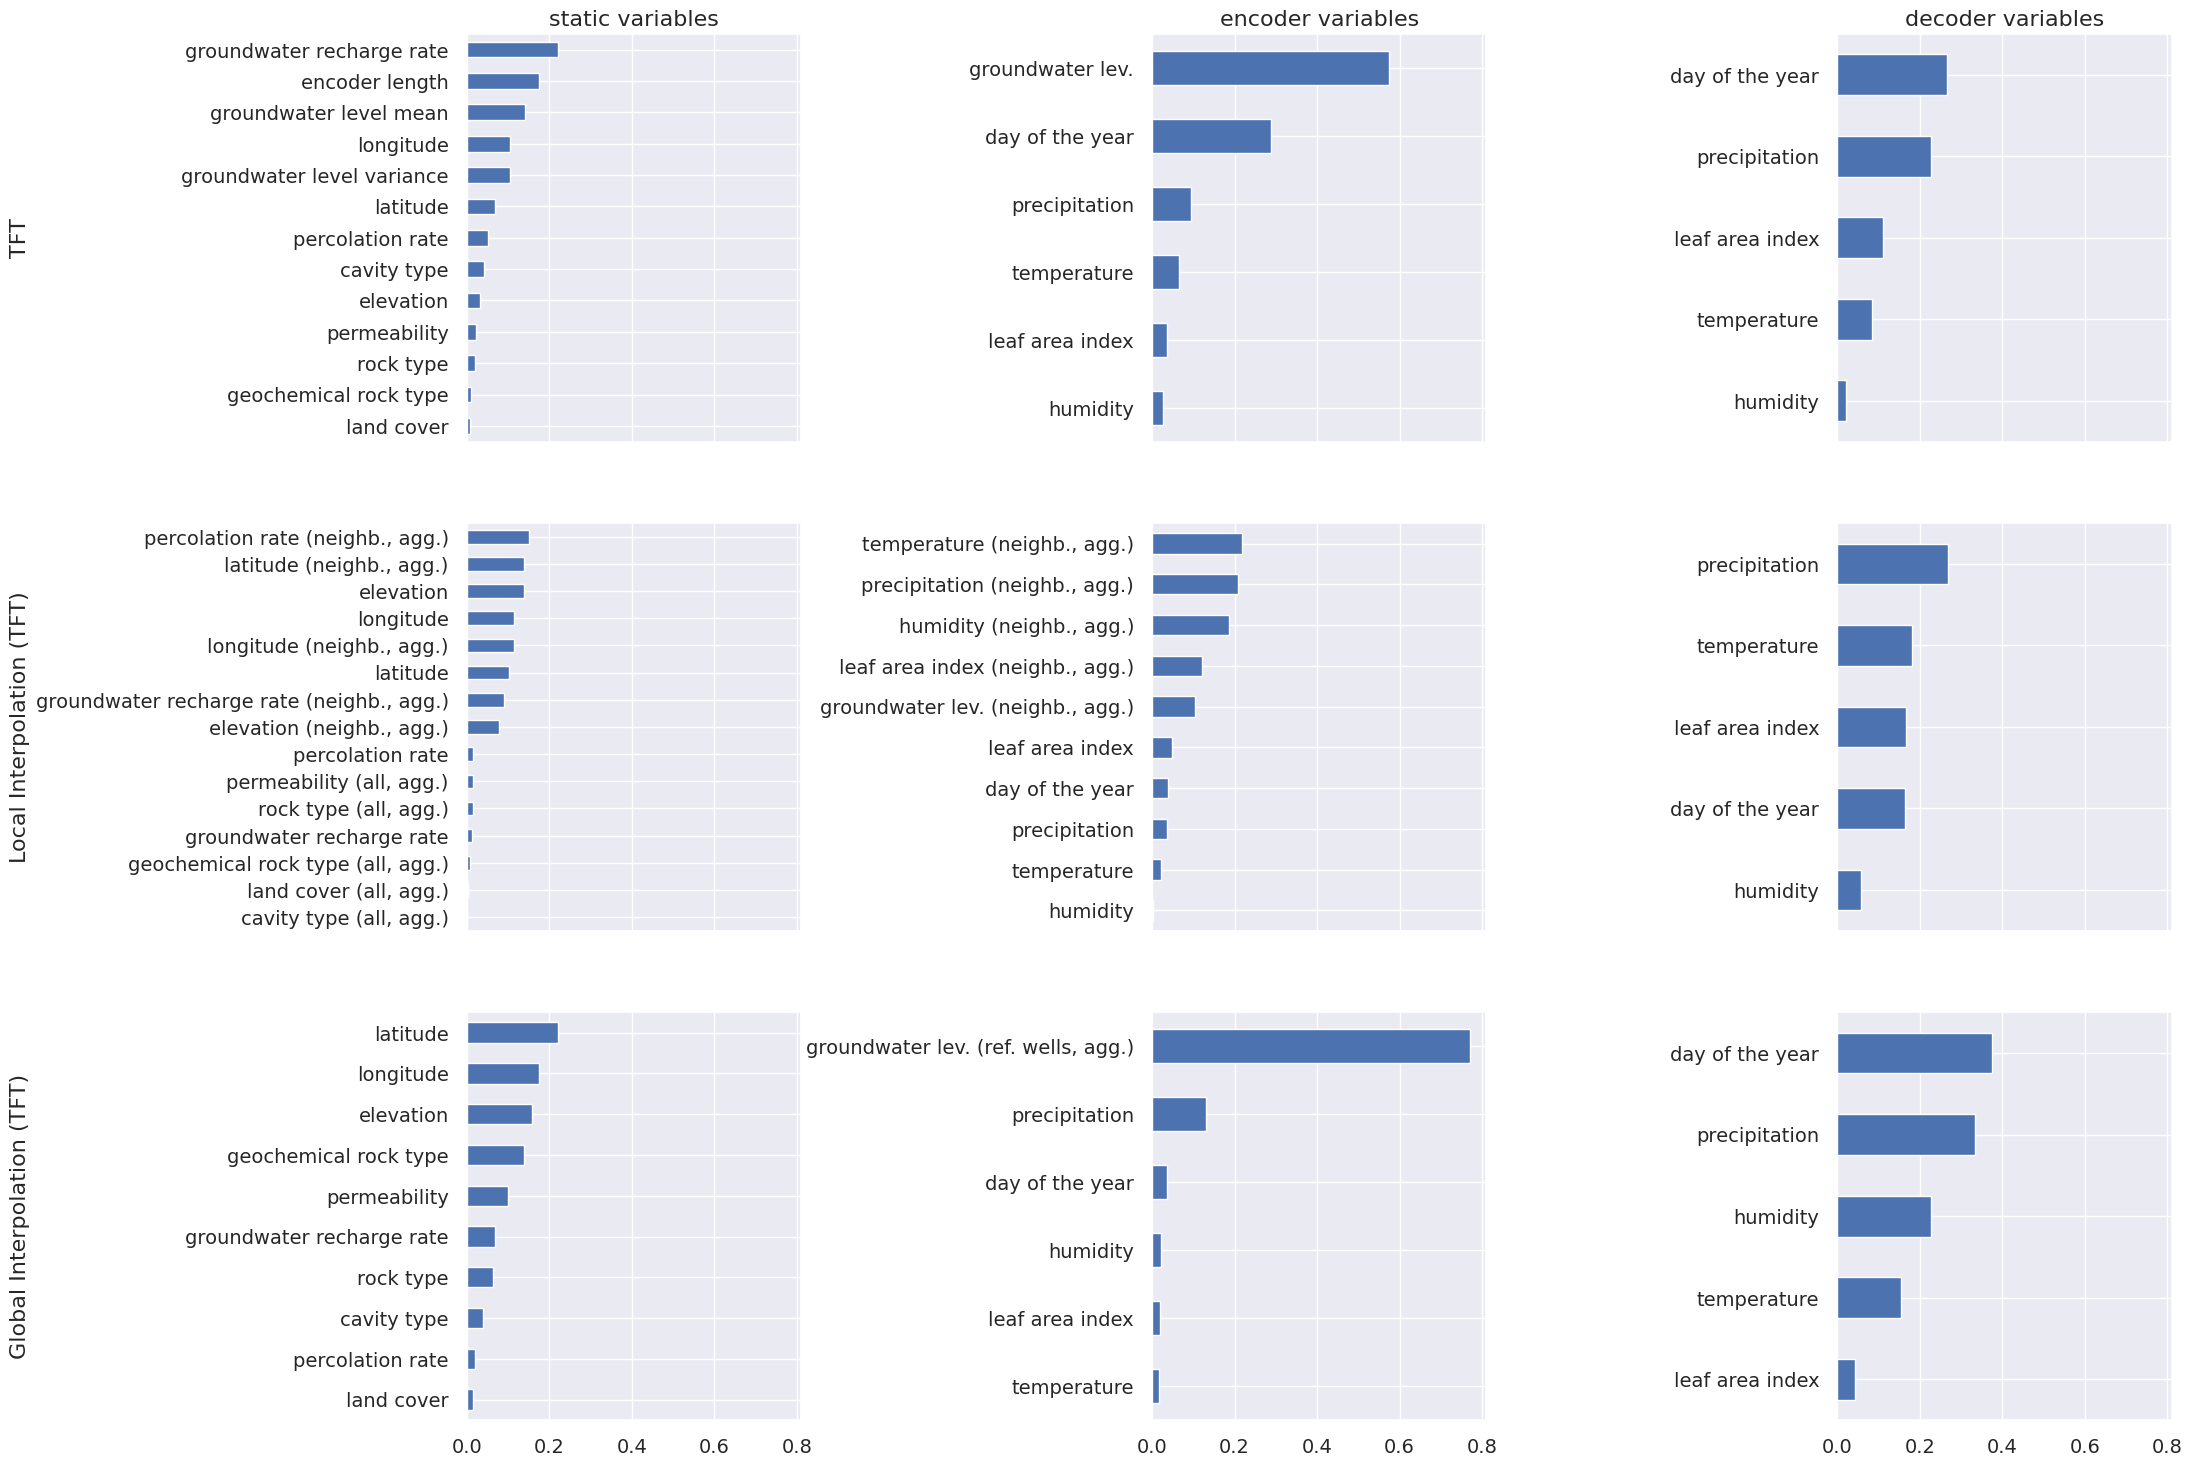

In [95]:
import json

N_NEIGHBORS = 6
N_REF_WELLS = 100
STATICS = {
    'gw_recharge': 'groundwater recharge rate',
    'encoder_length': 'encoder length',
    'gwl_center': 'groundwater level mean',
    'gwl_scale': 'groundwater level variance',
    'lon': 'longitude',
    'lat': 'latitude',
    'elevation': 'elevation',
    'cavity_type': 'cavity type',
    'permeability': 'permeability',
    'rock_type': 'rock type',
    'geochemical_rock_type': 'geochemical rock type',
    'land_cover': 'land cover',
    'percolation': 'percolation rate',
    'percolation_n': 'percolation rate (neighb., agg.)',
    'elevation_n': 'elevation (neighb., agg.)',
    'lat_n': 'latitude (neighb., agg.)',
    'lon_n': 'longitude (neighb., agg.)',
    'gw_recharge_n': 'groundwater recharge rate (neighb., agg.)',
    'g_rock_type': 'rock type (all, agg.)',
    'g_permeability': 'permeability (all, agg.)',
    'g_geochemical_rock_type': 'geochemical rock type (all, agg.)',
    'g_land_cover': 'land cover (all, agg.)',
    'g_cavity_type': 'cavity type (all, agg.)'
}

TEMPORALS = {
    'precipitation': 'precipitation',
    'humidity': 'humidity',
    'temperature': 'temperature',
    'gwl': 'groundwater lev.',
    'day': 'day of the year',
    'lai': 'leaf area index',
    'ref_gwl': 'groundwater lev. (ref. wells, agg.)',
    'gwl_n': 'groundwater lev. (neighb., agg.)',
    'precipitation_n': 'precipitation (neighb., agg.)',
    'humidity_n': 'humidity (neighb., agg.)',
    'temperature_n': 'temperature (neighb., agg.)',
    'lai_n': 'leaf area index (neighb., agg.)',
    
}


fig, ax = plt.subplots(3, 3, figsize=(22, 18), sharex=True)    

## TFT
with open(os.path.join(BASE_PATH, 'results', 'interpretation', 'tft_variable_importance.json')) as f:
    tft_interpretation = json.load(f)
    
tft_interpretation['encoder_variables']['day'] = tft_interpretation['encoder_variables']['day_sin'] + tft_interpretation['encoder_variables']['day_sin']
tft_interpretation['decoder_variables']['day'] = tft_interpretation['decoder_variables']['day_sin'] + tft_interpretation['decoder_variables']['day_sin']
del tft_interpretation['encoder_variables']['day_sin']
del tft_interpretation['encoder_variables']['day_cos']
del tft_interpretation['decoder_variables']['day_sin']
del tft_interpretation['decoder_variables']['day_cos']

tft_interpretation['static_variables'] = dict(zip([STATICS[k] for k in tft_interpretation['static_variables'].keys()], list(tft_interpretation['static_variables'].values())))
tft_interpretation['encoder_variables'] = dict(zip([TEMPORALS[k] for k in tft_interpretation['encoder_variables'].keys()], list(tft_interpretation['encoder_variables'].values())))
tft_interpretation['decoder_variables'] = dict(zip([TEMPORALS[k] for k in tft_interpretation['decoder_variables'].keys()], list(tft_interpretation['decoder_variables'].values())))

pd.Series(tft_interpretation['static_variables']).sort_values(ascending=True).plot.barh(ax=ax[0][0], title='static variables', ylabel='TFT')
pd.Series(tft_interpretation['encoder_variables']).sort_values(ascending=True).plot.barh(ax=ax[0][1], title='encoder variables')
pd.Series(tft_interpretation['decoder_variables']).sort_values(ascending=True).plot.barh(ax=ax[0][2], title='decoder variables')

## Local interpolation (TFT)
with open(os.path.join(BASE_PATH, 'results', 'interpretation', 'tft_local_interpolation_variable_importance.json')) as f:
    tft_loc_intp_interpretation = json.load(f)
    
tft_loc_intp_interpretation['encoder_variables']['day'] = tft_loc_intp_interpretation['encoder_variables']['day_sin'] + tft_loc_intp_interpretation['encoder_variables']['day_sin']
tft_loc_intp_interpretation['decoder_variables']['day'] = tft_loc_intp_interpretation['decoder_variables']['day_sin'] + tft_loc_intp_interpretation['decoder_variables']['day_sin']
del tft_loc_intp_interpretation['encoder_variables']['day_sin']
del tft_loc_intp_interpretation['encoder_variables']['day_cos']
del tft_loc_intp_interpretation['decoder_variables']['day_sin']
del tft_loc_intp_interpretation['decoder_variables']['day_cos']

for var in ['elevation', 'lat', 'lon', 'gw_recharge', 'percolation']:
    tft_loc_intp_interpretation['static_variables'][f'{var}_n'] = np.sum([tft_loc_intp_interpretation['static_variables'][f'{var}_n{i}'] for i in range(N_NEIGHBORS)])
    for i in range(N_NEIGHBORS):
        del tft_loc_intp_interpretation['static_variables'][f'{var}_n{i}']
    
tft_loc_intp_interpretation['static_variables'] = dict(zip([STATICS[k] for k in tft_loc_intp_interpretation['static_variables'].keys()], list(tft_loc_intp_interpretation['static_variables'].values())))
pd.Series(tft_loc_intp_interpretation['static_variables']).sort_values(ascending=True).plot.barh(ax=ax[1][0], ylabel='Local Interpolation (TFT)')   

for var in ['humidity', 'precipitation', 'lai', 'temperature', 'gwl']:
    tft_loc_intp_interpretation['encoder_variables'][f'{var}_n'] = np.sum([tft_loc_intp_interpretation['encoder_variables'][f'{var}_n{i}'] for i in range(N_NEIGHBORS)])
    for i in range(N_NEIGHBORS):
        del tft_loc_intp_interpretation['encoder_variables'][f'{var}_n{i}'] 

tft_loc_intp_interpretation['encoder_variables'] = dict(zip([TEMPORALS[k] for k in tft_loc_intp_interpretation['encoder_variables'].keys()], list(tft_loc_intp_interpretation['encoder_variables'].values())))
pd.Series(tft_loc_intp_interpretation['encoder_variables']).sort_values(ascending=True).plot.barh(ax=ax[1][1])

tft_loc_intp_interpretation['decoder_variables'] = dict(zip([TEMPORALS[k] for k in tft_loc_intp_interpretation['decoder_variables'].keys()], list(tft_loc_intp_interpretation['decoder_variables'].values())))
pd.Series(tft_loc_intp_interpretation['decoder_variables']).sort_values(ascending=True).plot.barh(ax=ax[1][2])

## Global interpolation (TFT)
with open(os.path.join(BASE_PATH, 'results', 'interpretation', 'tft_global_interpolation_variable_importance.json')) as f:
    tft_glob_intp_interpretation = json.load(f)

tft_glob_intp_interpretation['encoder_variables']['day'] = tft_glob_intp_interpretation['encoder_variables']['day_sin'] + tft_glob_intp_interpretation['encoder_variables']['day_sin']
tft_glob_intp_interpretation['decoder_variables']['day'] = tft_glob_intp_interpretation['decoder_variables']['day_sin'] + tft_glob_intp_interpretation['decoder_variables']['day_sin']
del tft_glob_intp_interpretation['encoder_variables']['day_sin']
del tft_glob_intp_interpretation['encoder_variables']['day_cos']
del tft_glob_intp_interpretation['decoder_variables']['day_sin']
del tft_glob_intp_interpretation['decoder_variables']['day_cos']

tft_glob_intp_interpretation['static_variables'] = dict(zip([STATICS[k] for k in tft_glob_intp_interpretation['static_variables'].keys()], list(tft_glob_intp_interpretation['static_variables'].values())))                                                                                                                                                  
pd.Series(tft_glob_intp_interpretation['static_variables']).sort_values(ascending=True).plot.barh(ax=ax[2][0], ylabel='Global Interpolation (TFT)')   

tft_glob_intp_interpretation['encoder_variables']['ref_gwl'] = np.sum([tft_glob_intp_interpretation['encoder_variables'][f'ref_well_{i}'] for i in range(N_REF_WELLS)])
for i in range(N_REF_WELLS):
    del tft_glob_intp_interpretation['encoder_variables'][f'ref_well_{i}'] 

tft_glob_intp_interpretation['encoder_variables'] = dict(zip([TEMPORALS[k] for k in tft_glob_intp_interpretation['encoder_variables'].keys()], list(tft_glob_intp_interpretation['encoder_variables'].values())))
pd.Series(tft_glob_intp_interpretation['encoder_variables']).sort_values(ascending=True).plot.barh(ax=ax[2][1])

tft_glob_intp_interpretation['decoder_variables'] = dict(zip([TEMPORALS[k] for k in tft_glob_intp_interpretation['decoder_variables'].keys()], list(tft_glob_intp_interpretation['decoder_variables'].values())))                                                                                                                                                  
pd.Series(tft_glob_intp_interpretation['decoder_variables']).sort_values(ascending=True).plot.barh(ax=ax[2][2])

fig.subplots_adjust(wspace=1.05)
fig.align_labels()
fig.savefig(os.path.join(FIGURES_PATH, 'variable_importance.pdf'), format='pdf', dpi=300.0)

### Supplement Tab: Metrics

In [34]:
MODEL_MAP_ORDER = {
    'nhits': 0,
    'tft': 2,
    'nhits_subset': 1,
    'tft_subset': 3,
    'tft_local_interpolation': 4,
    'tft_global_interpolation': 5,
}

MODEL_MAP = {
    0: 'N-HiTS',
    2: 'TFT',
    1: 'N-HiTS (subset)',
    3: 'TFT (subset)',
    4: 'Local Interpolation (TFT)',
    5: 'Global Interpolation (TFT)',
}

agg_metrics = metrics_df[['horizon', 'model', 'NSE', 'nRMSE', 'rMBE', 'Interval Score']].replace([np.inf, -np.inf, np.nan]).dropna().groupby(['model', 'horizon']).agg(['min', 'mean', 'median', 'max']).round(3)
agg_metrics.index = agg_metrics.index.map(lambda a: (MODEL_MAP_ORDER[a[0]], a[1]))
agg_metrics.sort_index(inplace=True)
agg_metrics.index = agg_metrics.index.map(lambda a: (MODEL_MAP[a[0]], a[1]))
agg_metrics.to_latex()

'\\begin{tabular}{llrrrrrrrrrrrrrrrr}\n\\toprule\n                           & metric & \\multicolumn{4}{l}{NSE} & \\multicolumn{4}{l}{nRMSE} & \\multicolumn{4}{l}{rMBE} & \\multicolumn{4}{l}{Interval Score} \\\\\n                           & {} &      min &   mean & median &    max &    min &   mean & median &     max &    min &   mean & median &    max &            min &   mean & median &     max \\\\\nmodel & horizon &          &        &        &        &        &        &        &         &        &        &        &        &                &        &        &         \\\\\n\\midrule\nN-HiTS & 1 &   -0.862 &  0.876 &  0.931 &  1.000 &  0.006 &  0.244 &  0.189 &   4.153 & -0.516 & -0.034 & -0.033 &  0.254 &          0.307 &  1.674 &  1.475 &   9.257 \\\\\n                           & 2 &   -3.776 &  0.812 &  0.882 &  1.000 &  0.005 &  0.307 &  0.246 &   5.294 & -1.442 & -0.029 & -0.029 &  0.577 &          0.378 &  1.951 &  1.758 &  16.932 \\\\\n                           & 3 &  -30

### Supplement Fig: Error Analysis

In [238]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose

TRAIN_PERIOD = (pd.Timestamp(1990, 1, 1), pd.Timestamp(2012, 1, 1))
TEST_PERIOD = (pd.Timestamp(2012, 1, 1), pd.Timestamp(2016, 1, 1))

_gwl_df = gwl_df.reset_index()
train_samples = _gwl_df[_gwl_df['time'].between(*TRAIN_PERIOD)]['proj_id'].value_counts()
gwl_stats = _gwl_df.groupby('proj_id')['gwl'].agg(['mean', 'std'])
neighbor_stats = pd.read_feather(os.path.join(BASE_PATH, 'results', 'predictions', 'tft_local_interpolation_test_df_stats.feather'))
ref_well_stats = pd.read_feather(os.path.join(BASE_PATH, 'results', 'predictions', 'tft_global_interpolation_test_df_stats.feather'))
test_samples = _gwl_df[_gwl_df['time'].between(*TEST_PERIOD) & (_gwl_df['proj_id'].isin(metrics_df['proj_id'].unique()))]
kpss_list = []
seasonality_list = []
for proj_id, group in test_samples.groupby('proj_id'):
    y = group['gwl'].dropna().values
    if len(group) >= 156:
        try:
            res = kpss(y)[0]
            kpss_list.append((proj_id, res))
        except:
            pass
        decomp = seasonal_decompose(y, period=52, two_sided=False)
        seasonality_list.append((proj_id, np.std(decomp.seasonal[52:])/np.std(decomp.resid[52:])))
kpss_df = pd.DataFrame(kpss_list, columns=['proj_id', 'stationarity'])
seas_df = pd.DataFrame(seasonality_list, columns=['proj_id', 'seasonality'])

_df = metrics_df[(metrics_df['horizon'] == 1) & (~metrics_df['model'].isin(['nhits_subset', 'tft_subset']))]
_df = _df.merge(static_df[['proj_id', 'elevation', 'mohplp_1', 'mohplp_6']], how='left', on='proj_id')
_df = _df.merge(train_samples.rename('train_count'), left_on='proj_id', right_index=True, how='left')
_df = _df.merge(gwl_stats, left_on='proj_id', right_index=True, how='left')
_df['gwl_bgl'] = _df['elevation'] - _df['mean']
_df = _df.merge(neighbor_stats, how='left', on='proj_id')
_df = _df.merge(ref_well_stats, how='left', on='proj_id')
_df = _df.merge(kpss_df, how='left', on='proj_id')
_df = _df.merge(seas_df, how='left', on='proj_id')
_df = _df.rename(columns={'mohplp_1': 'lateral position (I)', 'mohplp_6': 'lateral position (VI)',
                          'std': 'groundwater level variance', 'gwl_bgl': 'groundwater level depth', 
                          'hyraum_homogenity': 'hydrologic homogenity', 
                          'mean_neighbor_dist': 'average neighbor distance',
                          'min_ref_dist': 'minimum distance to reference well',
                          'train_count': 'training samples'})

_df

,proj_id,horizon,Interval Score,NSE,nRMSE,rMBE,model,elevation,lateral position (I),lateral position (VI),training samples,mean,groundwater level variance,groundwater level depth,average neighbor distance,hydriologic homogenity,minimum distance to reference well,stationarity,seasonality
0,BB_25470023,1,1.203,0.961,0.106,0.007,nhits,94.135468,0.369143,0.9407,581.0,78.898682,0.409257,15.236786,NaN,NaN,NaN,1.888399,0.566571
1,BB_25470024,1,1.203,0.961,0.106,0.007,nhits,94.135468,0.374841,0.9407,581.0,78.898682,0.409257,15.236786,NaN,NaN,NaN,1.888399,0.566571
2,BB_25480025,1,1.161,0.962,0.127,-0.008,nhits,53.223583,0.393800,0.9909,581.0,34.956631,0.230946,18.266953,NaN,NaN,NaN,1.640567,0.803277
3,BB_25480026,1,1.698,0.915,0.211,-0.022,nhits,97.625153,0.266569,0.8802,581.0,80.991447,0.428925,16.633705,NaN,NaN,NaN,1.360793,0.740550
4,BB_25481088,1,1.697,0.906,0.212,-0.003,nhits,54.072433,1.000000,0.9379,686.0,36.904469,0.285029,17.167965,NaN,NaN,NaN,1.826026,0.944339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23829,TH_5034210608,1,3.138,0.279,1.022,-0.218,tft_global_interpolation,234.493607,0.014500,0.5837,261.0,223.411514,0.290116,11.082092,59.609097,0.277778,76.632978,0.265264,0.472340
23830,TH_5227240535,1,4.257,-0.160,0.666,-0.253,tft_global_interpolation,256.194855,0.160200,0.9824,261.0,245.811829,0.427942,10.383026,57.550838,0.296296,39.276674,0.147891,0.342686
23831,TH_5429240534,1,1.764,0.713,0.352,-0.046,tft_global_interpolation,349.878754,0.352009,0.5623,261.0,333.965363,0.478991,15.913391,56.989288,0.185185,55.042271,0.528958,1.267539
23832,TH_5430240547,1,1.657,0.710,0.343,-0.067,tft_global_interpolation,446.784668,0.244400,0.5402,261.0,398.130066,1.128677,48.654602,60.822468,0.148148,66.007445,0.541810,1.356677


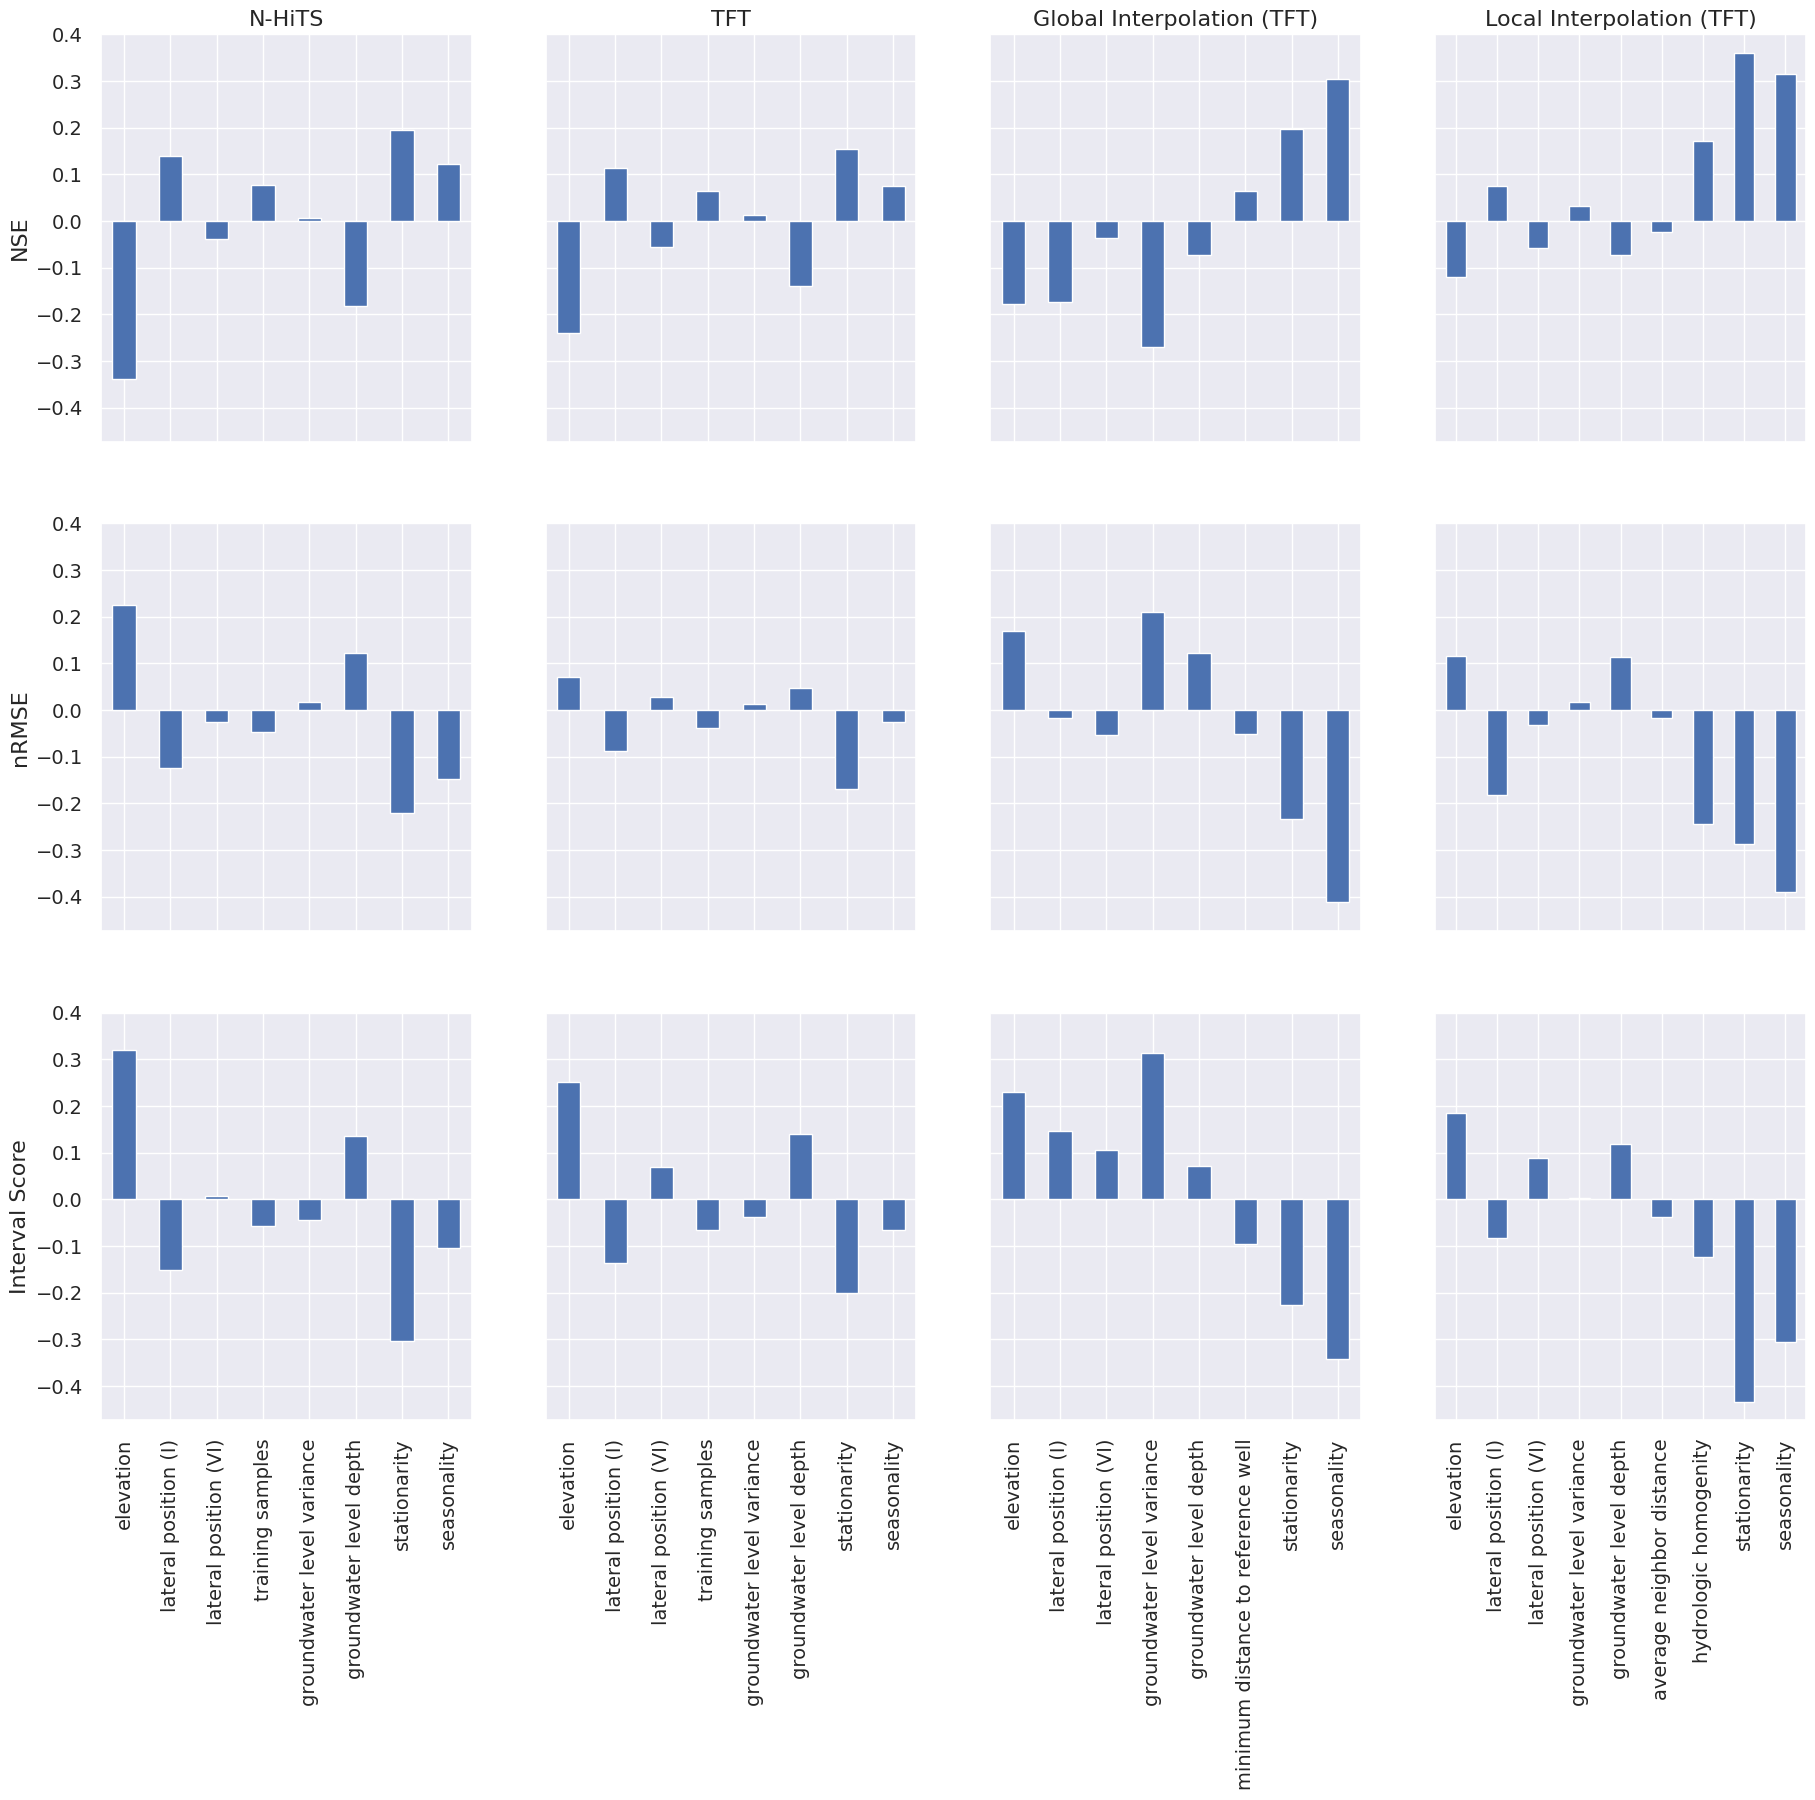

In [259]:
METRICS = {'NSE', 'Interval Score', 'nRMSE', 'rMBE'}
MODEL_MAP = {
    'nhits': 'N-HiTS',
    'tft': 'TFT',
    'tft_local_interpolation': 'Local Interpolation (TFT)',
    'tft_global_interpolation': 'Global Interpolation (TFT)',
}

fig, ax = plt.subplots(3, 4, figsize=(22, 18), sharey='all', sharex='col')

for j, metric in enumerate(['NSE', 'nRMSE', 'Interval Score']):
    corr = _df.drop(columns=['horizon', 'mean'] + list(METRICS.difference({metric}))).groupby('model').corr(method='pearson')[metric]
    for i, (model, group) in enumerate(corr.groupby(axis=0, level=0)):
        g = group.droplevel(0)
        del g[metric]
        if model in ['nhits', 'tft']:
            del g['minimum distance to reference well']
            del g['hydrologic homogenity']
            del g['average neighbor distance']
        else:
            del g['training samples']
            if model == 'tft_local_interpolation':
                del g['minimum distance to reference well']
            else:
                del g['average neighbor distance']
                del g['hydrologic homogenity']
        if j == 0:
            title = MODEL_MAP[model]
        else:
            title = None
        if i == 0:
            ylabel = metric
        else:
            ylabel = None
        g.plot.bar(ax=ax[j, i], title=title, ylabel=ylabel)
        
fig.savefig(os.path.join(FIGURES_PATH, 'error_correlation.pdf'), format='pdf', dpi=300.0)